# Dimensionality/Ordering Testing Notebook

The purpose of this notebook is to test how the input ordering of variables impacts the model's performance.

We find that inputting variables in the order of their relative importance allows the model to perform better than in the reversed/random order. Interestingly, all of them end up at the same performance level (MAE) when the last variable is introduced.

However, the model needs at least 5-6 of the most useful variables to be any good.

There are slight dimensionality concerns with adding noise but only really at lower sample sizes.

We can sift out which variables are more important than others.

## imports

In [1]:
# Set up
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared, DotProduct, Matern, WhiteKernel
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import random
np.random.seed(1226)

url = 'https://raw.githubusercontent.com/benkim1226/footballdata/master/gpr_var_length_scales.csv'
length_scales = pd.read_csv(url, index_col = 0)
length_scales.sort_values(by='length_scale')

,length_scale
h_tile,8.320719
rho_tile,12.656570
t_final,13.559468
k_tile,13.783874
cp_tile,14.162071
M_inf,15.335859
T_inf,23.483115
rho_Ti,40.048440
emissivity,41.388831
p_inf,42.077820


## creating data

In [2]:
from scipy.stats.qmc import LatinHypercube

In [3]:
from matplotlib.cm import datad
def create_data(sample):
  """
  Regardless of dimension, splitting the array into lists
You are subscribed to Colab Pro. Learn more.
Available: 88.02 compute units
Usage rate: approximately 10.89 per hour
You have 3 active sessions.
Want even more memory and disk space? Upgrade to Colab Pro+

  """

  d = {}

  for i in range(len(sample[0])):
    d["{0}".format(i)] = []

  keys = d.keys()

  for key in list(keys):
    for i in range(len(sample)):
      d[key] += [sample[i][int(key)]]

  return d

In [4]:
def standardizer(df):
  df_copy = df.copy()

  scaler = StandardScaler()
  df_copy = scaler.fit_transform(df_copy)
  df_copy = pd.DataFrame(df_copy)
  return(df_copy)

In [5]:
LHS_url = 'https://raw.githubusercontent.com/benkim1226/footballdata/master/LHS_complete.csv'
LHS_data = pd.read_csv(LHS_url, index_col = 0)
LHS_data = LHS_data.reset_index()

In [6]:
ordered_cols = ['h_tile','rho_tile','t_final','k_tile','cp_tile','M_inf','T_inf','rho_Ti',
                    'emissivity','p_inf','cp_Ti','h_Ti','fudge_factor','k_Ti']

In [7]:
engine = LatinHypercube(d=1)
sample = engine.random(n=1000)
sample = create_data(sample)

pd.DataFrame(sample)

,0
0,0.441591
1,0.243599
2,0.007159
3,0.689361
4,0.709444
...,...
995,0.801866
996,0.508770
997,0.289901
998,0.222388


## Model code

In [8]:
from math import sqrt
from array import *
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime as dt
import pandas as pd

In [9]:
def sutherland(T):
    """
    This function uses Sutherlands law to return dynamic viscosity for air as a function of temperature.
    Source: White, Viscous Fluid Flow, 3rd Edition Section 1-3.7

    Inputs
    ------
    T : float
        Temperature of air [K]

    Outputs
    -------
    mu : float
        Dynamic viscosity of air [N*s/m^2]

    Other Parameters
    ----------------
    T_ref: float
        Reference temperature of air [K]
    mu_ref: float
        Reference dynamic viscosity of air [N*s/m^2]
    S: float
        Sutherland constant for air [K]
    """

    # Reference Conditions for Air (From White Section 1-3.7 Table 1-2)
    T_ref = 273.0       # [K]
    mu_ref = 1.716e-5   # [N*s/m^2]
    S = 111.0           # [K]

    # Sutherland's Formula (White Section 1-3.7) (Note White uses T_0, mu_0 instead of T_ref, mu_ref)
    mu = mu_ref * ( (T/T_ref)**(3.0/2.0) * (T_ref + S)/(T + S) ) # [N*s/m^2]



    k_0 = 0.0241
    T_0 = 273 # [K]
    S_k = 194


    k = k_0 * ( (T/T_0)**(3.0/2.0) * (T_0 + S_k)/(T + S_k) ) # [W/(m*K)]

    return [mu, k]


In [10]:
def q_wall_fun(Tw, state, otherStuff):

    emissivity = otherStuff[0]
    M_inf = otherStuff[1]       # Freestream Mach number
    p_inf = otherStuff[2]       # Freestream pressure [Pa]
    T_inf = otherStuff[3]       # Freestream temperature [K]
    fudge_factor = otherStuff[4]

    edgeFlow = flowState()
    edgeFlow.fillMPT(M_inf, p_inf, T_inf)
    edgeFlow.state = state
    #edgeFlow.state = 'lam'
    #edgeFlow.state = 'turb'

    L = 1

    #Tw = 300      # Wall temperature [K]

    #f = lambda x: qwFun(x, edgeFlow, L, fudge_factor) - qradFun(x,emissivity)
    #Tw = bisection(f,100,2000,100)

    [qconv, Rex, Nu, Taw] = qwFun(Tw, edgeFlow, L, fudge_factor)
    qrad = qradFun(Tw,emissivity)

    #print("Tw = ", Tw)
    #print("qconv = ", qconv)
    #print("qrad = ", qrad)
    #print("Rex = ", Rex)
    #print("Nu = ", Nu)
    #print("Taw = ", Taw)

    qWall = qconv - qrad

 #   print("===")
 #   print("Tw = ", Tw)
 #   print("qWall = ", qWall)
 #   print("===")

    return qWall


def qradFun(Tw,emissivity):
    #emissivity = 0.8
    sigma = 5.6703e-8
    qrad = emissivity * sigma * Tw**4
    return qrad


def qwFun(Tw, edge, x, fudge_factor):
    """
    This function computes the convective heat flux for a flat plate.

    Inputs
    ------
    Tw : float
        Wall temperature [K]
    edge : flowState
        flowState at the edge of the boundary layer
    x : float
        Running length along the surface [m]

    Outputs
    -------
    qw : float
        Convective heat flux at the wall [W/m^2]
    """

    r = recoveryFactorFun(edge.Pr, edge.state)

    Taw = adiabaticWallTempFun(r, edge.T, edge.T0)

    Rex_e = edge.rho * edge.u * x / edge.mu



    if edge.state == 'lam':

        #T_star = edge.T * (0.5 + 0.039 * edge.M**2.0 + 0.5 * (Tw / edge.T))
        #CR_star = (T_star / edge.T)**(-1.0/3.0)
        #Rex_e = edge.rho * edge.u * x / edge.mu
        #cf = 0.664 * sqrt(CR_star) / sqrt(Rex_e)
        #ch = cf / (2.0 * edge.Pr**(2.0/3.0))
        #qw = ch * edge.rho * edge.u * edge.cp * (Taw - Tw)

        a = 0.332 # 0.453
        Nu = a * Rex_e**0.5*edge.Pr**(1.0/3.0)
        h = Nu*edge.k/x
        qw = h * (Taw - Tw)
        qw = qw * fudge_factor

    elif edge.state == 'turb':
        Nu = 0.0296 * Rex_e**0.8 * edge.Pr**0.6
        h = Nu*edge.k/x
        qw = h * (Taw - Tw)
        qw = qw * fudge_factor
    else:
        print('error')




    return [qw, Rex_e, Nu, Taw]

def edgeStateFun(M_inf, p_inf, T_inf):
    """
    This function computes a state vector of the flow properties at the edge of the boundary layer for a flat plate given the freestream conditions.

    Inputs
    ------
    M_inf : float
        Freestream Mach number

    p_inf : float
        Freestream pressure [Pa]

    T_inf : float
        Freestream temperature [K]

    Outputs
    ------
    edge : flowState
        flowState at the edge of the boundary layer
    """

    edge = flowState()

    edge.M = M_inf
    edge.p = p_inf
    edge.T = T_inf

    gamma_e = 1.4
    edge.cp = 1006.0 # [J/kg*K]
    R_e = 287.0 # [J/kg*K]

    a_e = sqrt(gamma_e * R_e * edge.T) # [m/s]
    edge.u = edge.M * a_e # [m/s]
    edge.rho = edge.p / (R_e * edge.T) # [kg/m^3]

    edge.mu = sutherland(edge.T)

    edge.T0 = edge.T + edge.u**2.0 / (2.0 * edge.cp)


    return edge

def recoveryFactorFun(Pr, flowState):
    """
    This function returns the recovery factor given the Prandtl number and the flow state (either laminar or turbulent).
    White, Viscous Fluid Flow, 3rd Edition Sections 7-3.1 and 7-8.3

    Inputs
    ------
    Pr : float
        Prandtl number

    flowState : str
        State of the flow: 'lam' for laminar or 'turb' for turbulent

    Outputs
    -------
    r : float
        Recovery factor
    """


    if flowState == 'lam':
        r = Pr**(0.5)   # White, Eq 7-37a in Section 7-3.1
    elif flowState == 'turb':
        r = Pr**(1.0/3.0) # White, Eq 7-136 in Section 7-8.3
    else:
        print('error')

    return r

def adiabaticWallTempFun(r, T_e, T0_e):
    """
    This function computes the adiabatic wall temperature given the recovery factor and static and total temperatures at the edge of the boundary layer.
    Source: White, Viscous Fluid Flow, 3rd Edition, Section 7-1.2

    Inputs
    ------
    r : float
        Recovery factor
    T_e : float
        Temperatures at the edge of the boundary layer [K]
    T0_e : float
        Total temperatures at the edge of the boundary layer [K]

    Outputs
    -------
    Taw : float
        Adiabatic wall temperature [K]
    """

    Taw = T_e + r * (T0_e - T_e) # White, Eq 7-16

    return Taw

class flowState:
    """
    This class represents the state variables at a point in a flow field.

    Attributes
    ----------
    M : float
        Mach number
    p : float
        Pressure [Pa]
    T : float
        Temperature [K]
    rho : float
        Density [kg/m^3]
    u : float
        Velocity magnitude [m/s]
    a : float
        Speed of sound [m/s]
    T0 : float
        Total temperature [K]
    p0 : float
        Total pressure [Pa]
    gamma : float
        Ratio of specific heats
    R : float
        Gas constant for air [J/kg*K]
    cp : float
        Specific heat at constant pressure [J/kg*K]
    mu : float
        Dynamic viscosity [N*s/m^2]
    Pr : float
        Prandtl number
    state : str
        State of the flow: 'lam' for laminar or 'turb' for turbulent

    Methods
    -------
    fillMPT(M, p, T)
        Fills the flow state using M, p, and T
    """

    def __init__(self):
        self.M      = []
        self.p      = []
        self.T      = []
        self.rho    = []
        self.u      = []
        self.a      = []
        self.q      = []
        self.p0     = []
        self.T0     = []
        self.gamma  = 1.4
        self.R      = 287.0     # [J/kg*K]
        self.cp     = 1004.5    # [J/kg*K]
        self.mu     = []
        self.k      = []
        self.Pr     = 0.72
        self.state  = []

    def fillMPT(self, M, p, T):
        """
        This method uses Mach, pressure, and temperature, along with the pre-defined thermodynamic states variables (gamma and R), to fill in most of the remaining flow state variables.
        """

        self.M = M
        self.p = p
        self.T = T

        self.a = sqrt(self.gamma * self.R * T) # [m/s]
        self.u = M * self.a # [m/s]
        self.rho = p / (self.R * T) # [kg/m^3]

        self.q = 0.5 * self.rho * self.u**2 #[Pa]

        [self.mu, self.k] = sutherland(T)

        self.T0 = T * (1.0 + 0.5*(self.gamma-1)*M**2)
        self.p0 = p * (1.0 + 0.5*(self.gamma-1)*M**2)**(self.gamma/(self.gamma-1))

In [11]:
def conductionFun(x_input, state, t_final):

    h_tile  = x_input[0]
    h_Ti    = x_input[1]

    rho_tile    = x_input[2]
    rho_Ti      = x_input[3]
    cp_tile     = x_input[4]
    cp_Ti       = x_input[5]
    k_tile      = x_input[6]
    k_Ti        = x_input[7]

    otherInputs = x_input[8:13]

    tps = TPSElement()

    #--- Outer BC ---
    #tps.OuterBCType = "fixedTemp"
    tps.OuterBCType = "fixedQ"
    #tps.TOuter = 600.0 # [K]
    #tps.qOuter = 141172.0 # [W/(m^2)]

    #--- Outer BC ---
    tps.InnerBCType = "insulated"
    tps.qInner = 0.0 # [W/(m^2)]

    #--- Initial Temperature ---
    tps.T0 = 300 # [K]

    #--- Define TPS Layrs ---
    #tps.layerThickness      = [0.0001, 0.007, 0.0001, 4*0.0254, 0.00015] #[m]
    #tps.rhoList             = [7117, 132, 7117, 96, 4437]                #[kg/m^3]
    #tps.cpList              = [625, 625, 625, 1150, 700]                 #[J/kg*K]
    #tps.kList               = [18, 0.35, 18, 0.05, 13]                   #[W/mK]
    #tps.nGridCellsPerLayer  = [4, 4, 4, 4, 4]

    tps.layerThickness      = [h_tile, h_Ti]   #[m]
    tps.rhoList             = [rho_tile, rho_Ti]           #[kg/m^3]
    tps.cpList              = [cp_tile, cp_Ti]            #[J/kg*K]
    tps.kList               = [k_tile, k_Ti]          #[W/mK]
    tps.nGridCellsPerLayer  = [50, 20]

    #tps.layerThickness      = [0.65*0.0254]   #[m]
    #tps.rhoList             = [144]           #[kg/m^3]
    #tps.cpList              = [628]            #[J/kg*K]
    #tps.kList               = [0.126]          #[W/mK]
    #tps.nGridCellsPerLayer  = [400]



    #--- Initialize the TPS Element ---
    tps.initializeTPS()
    tps.qOuter = q_wall_fun(tps.T[0], state, otherInputs)


#    print("==================================")
#    print("   time = ", tps.time)
#    print("==================================")
#    print("nLayers              = ", tps.nLayers)
#    print("nGridCellsPerLayer   = ", tps.nGridCellsPerLayer)
#    print("nGridCells           = ", tps.nGridCells)
#    print("delta_yPerLayer      = ", tps.delta_yPerLayer)
#    print("T[0]                 = ", tps.T[0])
#    print("T[end]               = ", tps.T[-1])
#    print("qOuter               = ", tps.qOuter)
    #print("delta_y              = ", tps.delta_y)
    #print("rho                  = ", tps.rho)
    #print("cp                   = ", tps.cp)
    #print("k                    = ", tps.k)
    #print("M = ")
    #print(tps.M)
    #print("T_RHS = ")
    #print(tps.T_RHS)

    delta_t = 0.1
    #tps.advance(delta_t)

    #t_final = 600

    for i in range(int(t_final/delta_t)):
        tps.advance(delta_t)
        tps.qOuter = q_wall_fun(tps.T[0], state, otherInputs)
        #print("Twall        = ", tps.T[0])

#    print(" ")
#    print("==================================")
#    print("   time = ", tps.time)
#    print("==================================")
#    print("qOuter       = ", tps.qOuter)
#    print("Twall        = ", tps.T[0])
#    print("T_Ti_outer   = ", tps.T[tps.nGridCellsPerLayer[0]])
#    print("T_Ti_inner   = ", tps.T[-1])
    #print("T = ", tps.T)

    return tps.T[tps.nGridCellsPerLayer[0]]

class TPSElement:
    """

    """

    def __init__(self):
        self.OuterBCType        = []
        self.InnerBCType        = []
        self.TOuter             = []
        self.TInner             = []
        self.qOuter             = []
        self.qInner             = []

        self.t0                 = 0.0       # Initial time
        self.time               = self.t0   # Time

        self.T0                 = []    # Initial temperature
        self.T                  = []    # Temperature

        self.y                  = []
        self.delta_y            = []
        self.delta_yPerLayer    = []

        self.nGridCellsPerLayer = []
        self.nGridCells         = []
        self.nLayers            = []
        self.layerThickness     = []

        self.rhoList            = []
        self.cpList             = []
        self.kList              = []

        self.rho                = []
        self.cp                 = []
        self.k                  = []

        self.M                  = []
        self.T_RHS              = []

    def initializeTPS(self):
        self.nLayers = len(self.layerThickness)

        self.nGridCells = 0
        for i in range(self.nLayers):
            self.nGridCells = self.nGridCells + self.nGridCellsPerLayer[i]

        self.delta_yPerLayer = [0] * self.nLayers
        for i in range(self.nLayers):
            self.delta_yPerLayer[i] = self.layerThickness[i] / self.nGridCellsPerLayer[i]

        self.T = [self.T0] * self.nGridCells

        self.delta_y = [0] * self.nGridCells
        self.rho     = [0] * self.nGridCells
        self.cp      = [0] * self.nGridCells
        self.k       = [0] * self.nGridCells

        counter = 0
        for i in range(self.nLayers):
            for j in range(self.nGridCellsPerLayer[i]):
                self.delta_y[counter]   = self.delta_yPerLayer[i]
                self.rho[counter]       = self.rhoList[i]
                self.cp[counter]        = self.cpList[i]
                self.k[counter]         = self.kList[i]
                counter = counter + 1

        self.M = np.empty(shape=(self.nGridCells,self.nGridCells))
        self.M.fill(0)

        self.T_RHS = np.empty(shape=(self.nGridCells,1))
        self.T_RHS.fill(0)

    def advance(self, delta_t):
        self.time = self.time + delta_t


        self.M[0][0] = -self.B(1)-self.A(0,delta_t)
        self.M[0][1] = self.B(1)
        self.T_RHS[0] = -self.A(0,delta_t) * self.T[0] - self.qOuter

        for i in range(1,self.nGridCells-1):
            self.M[i][i-1]   = self.B(i)
            self.M[i][i]     = -self.B(i) - self.B(i+1) - self.A(i,delta_t)
            self.M[i][i+1]   = self.B(i+1)
            self.T_RHS[i]    = -self.A(i,delta_t) * self.T[i]

        i_end = self.nGridCells - 1
        self.M[-1][-2] = self.B(i_end)
        self.M[-1][-1] = -self.B(i_end) - self.A(i_end,delta_t)
        self.T_RHS[-1] = -self.A(i_end,delta_t) * self.T[i_end] + self.qInner

        T_LHS = np.matmul(np.linalg.inv(self.M), self.T_RHS)

        self.T = list(T_LHS.flatten())

    def A(self, i, delta_t):

        A = self.rho[i] * self.cp[i] * self.delta_y[i] / delta_t

        return A

    def B(self, i):

        delta_y_avg = 0.5 * (self.delta_y[i] + self.delta_y[i-1])
        k_avg = (self.delta_y[i] * self.k[i] + self.delta_y[i-1] * self.k[i-1]) / (2.0 * delta_y_avg)

        B = k_avg / delta_y_avg

        return B


In [12]:
t_final     = 60    # [sec]

h_tile      = 0.0254     # [m]
h_Ti        = 0.00015    # [m]

rho_tile    = 144   # [kg/m^3]
rho_Ti      = 4540  # [kg/m^3]
cp_tile     = 628   # [J/kg*K]
cp_Ti       = 460   # [J/kg*K]
k_tile      = 0.126 # [W/mK]
k_Ti        = 7.1   # [W/mK]

emissivity  = 0.8

M_inf = 5.0     # Freestream Mach number
p_inf = 2736.0  # Freestream pressure [Pa]
T_inf = 284.0   # Freestream temperature [K]

fudge_factor = 1.0

x_input = [h_tile, h_Ti, rho_tile, rho_Ti, cp_tile, cp_Ti, k_tile, k_Ti,emissivity, M_inf, p_inf, T_inf, fudge_factor]

In [13]:
def run_model(x_input,t_final):
    T_Ti = conductionFun(x_input, 'turb', t_final)

    return T_Ti

## Specifying columns

In [14]:
url = 'https://raw.githubusercontent.com/benkim1226/footballdata/master/simulated_data_1000.csv'
s = 500
data = pd.read_csv(url, index_col = 0).loc[0:s]
data = data[['h_tile','rho_tile', 't_final','k_tile', 'cp_tile', 'M_inf','T_inf', 'rho_Ti', 'emissivity',  'p_inf','cp_Ti', 'h_Ti','fudge_factor','k_Ti','simulation_values']]

cols = ['h_tile','rho_tile', 't_final','k_tile', 'cp_tile', 'M_inf','T_inf', 'rho_Ti', 'emissivity',  'p_inf','cp_Ti', 'h_Ti','fudge_factor','k_Ti','simulation_values']

ordered_cols = ['h_tile','rho_tile','t_final','k_tile','cp_tile','M_inf','T_inf','rho_Ti',
                    'emissivity','p_inf','cp_Ti','h_Ti','fudge_factor','k_Ti'] # can permute this

constant_cols = [0.0254 , 144, 60, 0.126, 628, 5.0 , 284.0, 4540, 0.8, 2736.0 , 460, 0.00015, 1.0, 7.1]

## shuffle_lists

In [15]:
import random

def shuffle_lists(list1, list2):
    # Get the length of the lists
    length = len(list1)

    # Create a shuffled list of indices
    indices = list(range(length))
    random.shuffle(indices)

    # Create a new list by shuffling the elements of the original lists
    new_list1 = []
    new_list2 = []
    for index in indices:
        new_list1.append(list1[index])
        new_list2.append(list2[index])

    return new_list1, new_list2

## LHS_data

In [16]:
LHS_url = 'https://raw.githubusercontent.com/benkim1226/footballdata/master/LHS_complete.csv'
LHS_data = pd.read_csv(LHS_url, index_col = 0)
LHS_data = LHS_data.reset_index()

LHS_data.columns = ['t_final','h_tile','h_Ti','rho_tile','rho_Ti','cp_tile','cp_Ti','k_tile','k_Ti',
                    'emissivity', 'M_inf', 'p_inf', 'T_inf', 'fudge_factor','simulation_values']

run_model_cols = ['t_final','h_tile','h_Ti','rho_tile','rho_Ti','cp_tile','cp_Ti','k_tile','k_Ti',
                        'emissivity', 'M_inf', 'p_inf', 'T_inf', 'fudge_factor']

LHS_X_data = LHS_data.drop('simulation_values',axis=1)

In [17]:
LHS_X_data = LHS_X_data.loc[:,run_model_cols]

New_X_test  = standardizer(LHS_X_data)

indexes = random.sample(range(0, len(New_X_test)), 100)

New_X_test = New_X_test.loc[indexes]
New_y_test = LHS_data['simulation_values'].loc[indexes]

## dimension_test

In [18]:
sample_size = 75

Avg_Train_MAE = []
Avg_New_Test_MAE = []
Avg_Test_MAE = []

runs_per_dim = 20

sample_data = pd.DataFrame(np.random.randint(0,10, size=(sample_size,0)))

def dimension_test(sample_data, New_X_test, New_y_test):

  from IPython.display import clear_output

  LHS_url = 'https://raw.githubusercontent.com/benkim1226/footballdata/master/LHS_complete.csv'
  LHS_data = pd.read_csv(LHS_url, index_col = 0)
  LHS_data = LHS_data.reset_index()

  LHS_data.columns = ['t_final','h_tile','h_Ti','rho_tile','rho_Ti','cp_tile','cp_Ti','k_tile','k_Ti',
                    'emissivity', 'M_inf', 'p_inf', 'T_inf', 'fudge_factor','simulation_values']

  for i in range(len(data.columns)-1):

    print("Starting Column #"+str(i))

    sample_data[new_ordered_cols[i]] = 0

    print(new_ordered_cols[i])

    print(sample_data.head())

    n_hypercube = i + 1
    print("n_hypercube = "+str(n_hypercube))

    n_constants = len(data.columns) - i - 2
    print("n_constants = "+str(n_constants))

    # CREATING NEW LATIN HYPERCUBE

    engine = LatinHypercube(d= n_hypercube)
    LHS = engine.random(n= sample_size)

    LHS = create_data(LHS)
    LHS = pd.DataFrame(LHS)

    print(LHS.head())

    a = []
    b = []

    X_data = data.drop('simulation_values',axis=1)
    X_data = X_data.loc[:,new_ordered_cols]

    for column in X_data.columns: # the problem!
      b.append(max(X_data[column]))
      a.append(min(X_data[column]))

    for i in range(len(LHS.columns)):
      LHS.iloc[:,i] = a[i] +(b[i] - a[i])*LHS.iloc[:,i]

    # ----
    # Filling in with constants
    # ----

    constant_col_names = new_ordered_cols[n_hypercube:]
    varied_col_names = new_ordered_cols[:n_hypercube]

    for i in range(n_constants):

      #constant_cols = [0.0254 , 144, 60, 0.126, 628, 5.0 , 284.0, 4540, 0.8, 2736.0 , 460, 0.00015, 1.0, 7.1]
      constant_cols = new_constant_cols[n_hypercube:]

      LHS[constant_col_names[i]] = constant_cols[i]

    LHS.columns = varied_col_names + constant_col_names

    # ----
    # Column ordering
    # ----

    print(LHS.head())

    simulation_values = []

    for row in range(len(LHS)):

      run_model_cols = LHS.columns.tolist()

      run_model_cols = ['t_final','h_tile','h_Ti','rho_tile','rho_Ti','cp_tile','cp_Ti','k_tile','k_Ti',
                        'emissivity', 'M_inf', 'p_inf', 'T_inf', 'fudge_factor']

      LHS = LHS[run_model_cols]

      values = LHS.loc[row]

      simulation_value = run_model(values[1:],values[0])
      simulation_values.append(simulation_value) # make sure t_final is [0]

      print("row "+str(row)+": T_Ti = "+str(simulation_value))

      clear_output()

    # ----
    # Training model
    # ----

    LHS['simulated_values'] = simulation_values


    X = LHS.drop('simulated_values',axis=1)
    X = standardizer(X) #!!!

    y = LHS['simulated_values']

    Train_MAE = []
    Test_MAE = []
    New_Test_MAE = []

    # --- NEW TEST ---

    for run in range(runs_per_dim):

      print("Starting Run #"+str(run))

      print("Train test splitting")

      from sklearn.model_selection import train_test_split

      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

      print("Train test splitted")


      # -----
      # GPR
      # -----

      constant = 1
      length_scale_array = np.array([1]*len(X.columns))

      kernel = constant * RBF(length_scale= length_scale_array, length_scale_bounds=(1e-3, 1e3))
      gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y = True)

      model = gpr

      print("Fitting model")

      model.fit(X_train, y_train)

      print("Model fitted")

      Test_MAE_obs = mean_absolute_error(y_test, model.predict(X_test)) # change X_test and Y_test
      New_Test_MAE_obs = mean_absolute_error(New_y_test, model.predict(New_X_test))
      Train_MAE_obs = mean_absolute_error(y_train, model.predict(X_train))

      Test_MAE.append(Test_MAE_obs)
      New_Test_MAE.append(New_Test_MAE_obs)
      Train_MAE.append(Train_MAE_obs)

      print("Test MAE = "+str(round(Test_MAE_obs,4))) # is the model good?
      print("New Test MAE = "+str(round(New_Test_MAE_obs,4)))

      clear_output()

    Avg_Train_MAE.append(np.mean(Train_MAE))
    #print("Train MAE = "+Avg_Train_MAE)

    Avg_Test_MAE.append(np.mean(Test_MAE))
    #print("Test MAE = "+Avg_Test_MAE)

    Avg_New_Test_MAE.append(np.mean(New_Test_MAE))

  return Avg_New_Test_MAE

## Executing function

In [19]:
# RANDOM/SHUFFLED ORDER

new_ordered_cols, new_constant_cols = shuffle_lists(ordered_cols, constant_cols)

Avg_New_Test_MAE = []
Test_MAE_random = dimension_test(sample_data, New_X_test, New_y_test)

# CORRECT ORDER

new_ordered_cols = ordered_cols
new_constant_cols = constant_cols

Avg_New_Test_MAE = []
Test_MAE_ordered = dimension_test(sample_data, New_X_test, New_y_test)

# REVERSED ORDER

new_ordered_cols = ordered_cols[len(ordered_cols) - 1::-1] #
new_constant_cols = constant_cols[len(constant_cols) - 1::-1]

Avg_New_Test_MAE = []
Test_MAE_reversed = dimension_test(sample_data, New_X_test, New_y_test)


row 40: T_Ti = 340.0948594185445
row 41: T_Ti = 341.8295607125126
row 42: T_Ti = 325.12911526614494
row 43: T_Ti = 339.90400211067475
row 44: T_Ti = 347.01800786973024
row 45: T_Ti = 329.53566905054885
row 46: T_Ti = 352.70691770593646
row 47: T_Ti = 317.0248573873006
row 48: T_Ti = 340.90341475004675
row 49: T_Ti = 356.81274718699274
row 50: T_Ti = 337.7573559787724
row 51: T_Ti = 342.1023976880938
row 52: T_Ti = 323.74486329008107
row 53: T_Ti = 335.7383062583213
row 54: T_Ti = 349.7962502916552
row 55: T_Ti = 334.00183572884646
row 56: T_Ti = 355.8935061914963
row 57: T_Ti = 333.71528644278106
row 58: T_Ti = 339.936730725249
row 59: T_Ti = 336.84288355979913
row 60: T_Ti = 358.512746767467
row 61: T_Ti = 345.6529355305832
row 62: T_Ti = 352.3593223166243
row 63: T_Ti = 336.8827712584704
row 64: T_Ti = 329.33715244566935
row 65: T_Ti = 337.0710497652198
row 66: T_Ti = 344.1315194711724
row 67: T_Ti = 329.3492519580252
row 68: T_Ti = 342.20630010826085
row 69: T_Ti = 350.6229790248368

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 0.4138
New Test MAE = 9.9231
Starting Run #2
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 0.543
New Test MAE = 9.835
Starting Run #3
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 0.5578
New Test MAE = 9.8011
Starting Run #4
Train test splitting
Train test splitted
Fitting model
Model fitted
Test MAE = 0.7425
New Test MAE = 9.7949
Starting Run #5
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 0.423
New Test MAE = 9.8029
Starting Run #6
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 0.6657
New Test MAE = 9.8381
Starting Run #7
Train test splitting
Train test splitted
Fitting model
Model fitted
Test MAE = 0.3492
New Test MAE = 9.8527
Starting Run #8
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 0.5495
New Test MAE = 9.7718
Starting Run #9
Train test splitting
Train test splitted
Fitting model
Model fitted
Test MAE = 0.4382
New Test MAE = 9.7921
Starting Run #10
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 0.3717
New Test MAE = 9.7633
Starting Run #11
Train test splitting
Train test splitted
Fitting model
Model fitted
Test MAE = 0.3593
New Test MAE = 9.822
Starting Run #12
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 0.3554
New Test MAE = 14.0785
Starting Run #13
Train test splitting
Train test splitted
Fitting model
Model fitted
Test MAE = 0.4672
New Test MAE = 9.8042
Starting Run #14
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 0.4797
New Test MAE = 9.7632
Starting Run #15
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 0.4722
New Test MAE = 9.8017
Starting Run #16
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 0.5311
New Test MAE = 9.8244
Starting Run #17
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 0.5701
New Test MAE = 14.1608
Starting Run #18
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 0.5626
New Test MAE = 9.7771
Starting Run #19
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 0.5226
New Test MAE = 9.7603
Starting Column #13
h_tile
   emissivity  fudge_factor  p_inf  k_Ti  t_final  k_tile  rho_Ti  M_inf  \
0           0             0      0     0        0       0       0      0   
1           0             0      0     0        0       0       0      0   
2           0             0      0     0        0       0       0      0   
3           0             0      0     0        0       0       0      0   
4           0             0      0     0        0       0       0      0   

   T_inf  h_tile  rho_tile  h_Ti  cp_Ti  cp_tile  
0      0       0         0     0      0        0  
1      0       0         0     0      0        0  
2      0       0         0     0      0        0  
3      0       0         0     0      0        0  
4      0       0         0     0      0        0  
n_hypercube = 14
n_constants = 0
          0         1         2         3         4         5         6  \
0  0.209065  0.556528  0.710526  0.699123  0.4099

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 0.7726
New Test MAE = 0.8068
Starting Run #1
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 1.2934
New Test MAE = 1.1506
Starting Run #2
Train test splitting
Train test splitted
Fitting model
Model fitted
Test MAE = 1.034
New Test MAE = 0.9004
Starting Run #3
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 0.8438
New Test MAE = 1.0901
Starting Run #4
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 1.1147
New Test MAE = 1.1349
Starting Run #5
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 0.9787
New Test MAE = 0.8726
Starting Run #6
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 1.2344
New Test MAE = 1.1601
Starting Run #7
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 1.7499
New Test MAE = 1.1377
Starting Run #8
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 0.9903
New Test MAE = 0.9206
Starting Run #9
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 1.1437
New Test MAE = 0.9706
Starting Run #10
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 1.0611
New Test MAE = 0.8688
Starting Run #11
Train test splitting
Train test splitted
Fitting model
Model fitted
Test MAE = 1.3503
New Test MAE = 1.0316
Starting Run #12
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 1.0911
New Test MAE = 0.893
Starting Run #13
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 1.0267
New Test MAE = 0.9149
Starting Run #14
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 0.9165
New Test MAE = 0.9544
Starting Run #15
Train test splitting
Train test splitted
Fitting model
Model fitted
Test MAE = 0.7559
New Test MAE = 0.715
Starting Run #16
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 0.9967
New Test MAE = 0.8787
Starting Run #17
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 1.251
New Test MAE = 0.9264
Starting Run #18
Train test splitting
Train test splitted
Fitting model


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Model fitted
Test MAE = 1.1398
New Test MAE = 1.1467
Starting Run #19
Train test splitting
Train test splitted
Fitting model
Model fitted
Test MAE = 1.1736
New Test MAE = 0.9212


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


## Plotting each order

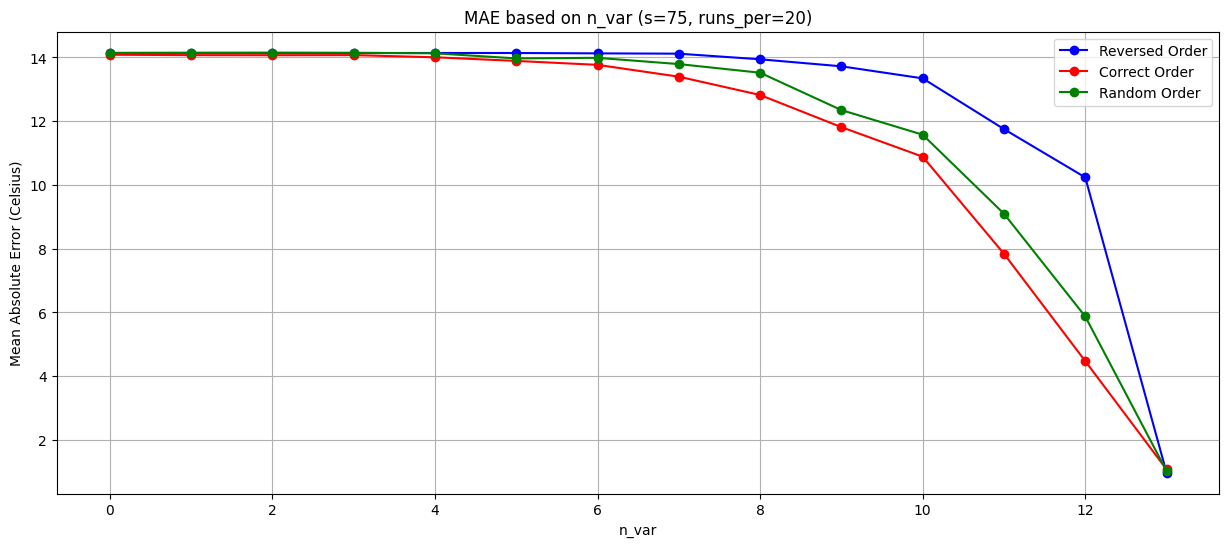

In [20]:
# Plotting the MAE of the testng and training sets based off of sample size
n_var = range(len(new_ordered_cols))

plt.figure(figsize=(15,6))

plt.plot(n_var, Test_MAE_reversed, 'o-', color='blue', label='Reversed Order')
plt.plot(n_var, Test_MAE_ordered, 'o-', color='red', label='Correct Order')
plt.plot(n_var, Test_MAE_random, 'o-', color='green', label='Random Order')

plt.legend()
plt.grid()
plt.xlabel('n_var')
plt.ylabel('Mean Absolute Error (Celsius)')
plt.title('MAE based on n_var (s=' +str(sample_size)+', runs_per='+str(runs_per_dim)+')')
plt.show()

## Dimension to Dimension comparison*

Comparing each dimension with its testing counterpart of the same dimensionality (as to avoid extrapolating on columns of zero's)

*best graph yet

In [23]:
sample_size = 75

Avg_Train_MAE = []
Avg_New_Test_MAE = []
Avg_Test_MAE = []

runs_per_dim = 20

sample_data = pd.DataFrame(np.random.randint(0,10, size=(sample_size,0)))

def dimension_test_2(sample_data):

  from IPython.display import clear_output

  LHS_url = 'https://raw.githubusercontent.com/benkim1226/footballdata/master/LHS_complete.csv'
  LHS_data = pd.read_csv(LHS_url, index_col = 0)
  LHS_data = LHS_data.reset_index()

  LHS_data.columns = ['t_final','h_tile','h_Ti','rho_tile','rho_Ti','cp_tile','cp_Ti','k_tile','k_Ti',
                    'emissivity', 'M_inf', 'p_inf', 'T_inf', 'fudge_factor','simulation_values']

  for i in range(len(data.columns)-1):

    print("Starting Column #"+str(i))

    sample_data[new_ordered_cols[i]] = 0

    n_hypercube = i + 1
    print("n_hypercube = "+str(n_hypercube))

    n_constants = len(data.columns) - i - 2
    print("n_constants = "+str(n_constants))


    # CREATING NEW LATIN HYPERCUBE

    engine = LatinHypercube(d= n_hypercube)
    LHS = engine.random(n= sample_size)

    LHS = create_data(LHS)
    LHS = pd.DataFrame(LHS)


    a = []
    b = []

    X_data = data.drop('simulation_values',axis=1)
    X_data = X_data.loc[:, new_ordered_cols]

    for column in X_data.columns: # the problem!
      b.append(max(X_data[column]))
      a.append(min(X_data[column]))

    for col in range(len(LHS.columns)):
      LHS.iloc[:,col] = a[col] +(b[col] - a[col])*LHS.iloc[:,col]

    # ----
    # Filling in with constants
    # ----

    constant_col_names = new_ordered_cols[n_hypercube:]
    varied_col_names = new_ordered_cols[:n_hypercube]

    for constant in range(n_constants):

      #constant_cols = [0.0254 , 144, 60, 0.126, 628, 5.0 , 284.0, 4540, 0.8, 2736.0 , 460, 0.00015, 1.0, 7.1]
      constant_cols = new_constant_cols[n_hypercube:]

      LHS[constant_col_names[constant]] = constant_cols[constant]

    LHS.columns = varied_col_names + constant_col_names

    # ----
    # Column ordering
    # ----

    simulation_values = []

    for row in range(len(LHS)):

      run_model_cols = LHS.columns.tolist()

      run_model_cols = ['t_final','h_tile','h_Ti','rho_tile','rho_Ti','cp_tile','cp_Ti','k_tile','k_Ti',
                        'emissivity', 'M_inf', 'p_inf', 'T_inf', 'fudge_factor']

      LHS = LHS[run_model_cols]

      values = LHS.loc[row]

      simulation_value = run_model(values[1:],values[0])
      simulation_values.append(simulation_value) # make sure t_final is [0]

      print("row "+str(row)+": T_Ti = "+str(simulation_value))

      clear_output()

    # ----
    # Creating training data
    # ----
    LHS = LHS.loc[:,new_ordered_cols]

    LHS['simulation_values'] = simulation_values

    X = LHS.drop('simulation_values',axis=1)

    X = X.iloc[:,0:i+1] # KEY DIFFERENCE IN THIS CODE VERSION

    X = standardizer(X)
    y = LHS['simulation_values']

    Train_MAE = []
    Test_MAE = []
    New_Test_MAE = []

    # --- NEW TEST ---

    LHS_X_data = LHS_data.drop('simulation_values',axis=1)
    LHS_X_data = LHS_X_data.loc[:,new_ordered_cols]

    New_X_test = LHS_X_data.iloc[:,0:i+1] # same dim as X

    New_X_test  = standardizer(New_X_test)

    indexes = random.sample(range(0, len(New_X_test)), 100)

    New_X_test = New_X_test.loc[indexes] # this works!!!
    New_y_test = LHS_data['simulation_values'].loc[indexes]

    # --- Training model ---


    for run in range(runs_per_dim):

      print("Starting Run #"+str(run))

      print("Train test splitting")

      from sklearn.model_selection import train_test_split

      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

      print("Train test splitted")

      # -----
      # GPR
      # -----

      constant = 1
      length_scale_array = np.array([1]*len(X.columns))

      kernel = constant * RBF(length_scale= length_scale_array, length_scale_bounds=(1e-3, 1e3))+ WhiteKernel(noise_level = 100)
      gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y = True)

      model = gpr

      print("Fitting model")

      model.fit(X_train, y_train)

      print("Model fitted")

      Test_MAE_obs = mean_absolute_error(y_test, model.predict(X_test)) # change X_test and Y_test
      New_Test_MAE_obs = mean_absolute_error(New_y_test, model.predict(New_X_test))
      Train_MAE_obs = mean_absolute_error(y_train, model.predict(X_train))

      Test_MAE.append(Test_MAE_obs)
      New_Test_MAE.append(New_Test_MAE_obs)
      Train_MAE.append(Train_MAE_obs)

      print("Test MAE = "+str(round(Test_MAE_obs,4))) # is the model good?
      print("New Test MAE = "+str(round(New_Test_MAE_obs,4)))

      clear_output()

    Avg_Train_MAE.append(np.mean(Train_MAE))
    #print("Train MAE = "+Avg_Train_MAE)

    Avg_Test_MAE.append(np.mean(Test_MAE))
    #print("Test MAE = "+Avg_Test_MAE)

    Avg_New_Test_MAE.append(np.mean(New_Test_MAE))

  return Avg_New_Test_MAE

## Executing Function

In [ ]:
# RANDOM/SHUFFLED ORDER

new_ordered_cols, new_constant_cols = shuffle_lists(ordered_cols, constant_cols)

Avg_New_Test_MAE = []
Test_MAE_random = dimension_test_2(sample_data)

# CORRECT ORDER

new_ordered_cols = ordered_cols
new_constant_cols = constant_cols

Avg_New_Test_MAE = []
Test_MAE_ordered = dimension_test_2(sample_data)

# REVERSED ORDER

new_ordered_cols = ordered_cols[len(ordered_cols) - 1::-1] #
new_constant_cols = constant_cols[len(constant_cols) - 1::-1]

Avg_New_Test_MAE = []
Test_MAE_reversed = dimension_test_2(sample_data)


row 56: T_Ti = 351.7310830818589


## Graphing

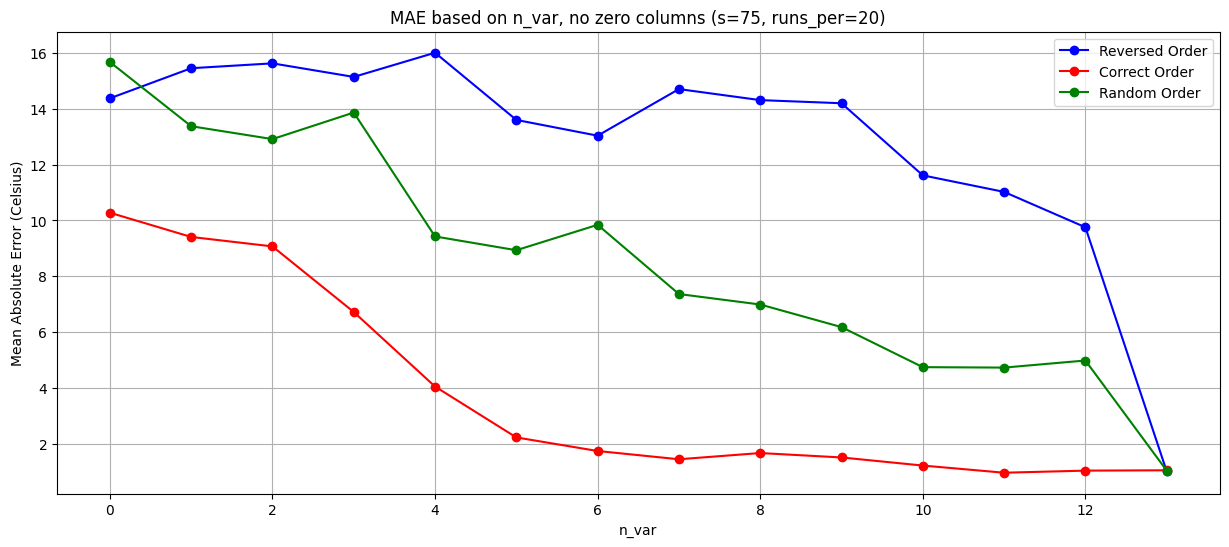

In [25]:
# Plotting the MAE of the testng and training sets based off of sample size
n_var = range(len(new_ordered_cols))

plt.figure(figsize=(15,6))

plt.plot(n_var, Test_MAE_reversed, 'o-', color='blue', label='Reversed Order')
plt.plot(n_var, Test_MAE_ordered, 'o-', color='red', label='Correct Order')
plt.plot(n_var, Test_MAE_random, 'o-', color='green', label='Random Order')

plt.legend()
plt.grid()
plt.xlabel('n_var')
plt.ylabel('Mean Absolute Error (Celsius)')
plt.title('MAE based on n_var, no zero columns (s=' +str(sample_size)+', runs_per='+str(runs_per_dim)+')')
plt.show()